# A super basic demo on Probabilistic programming in 5 minutes or less 

This is intended to be a very simple introduction to Probabilistic programming with Python. If this is your first encounter with a Python notebook all you have to do is to locate the cursor in a cell and:

* Go the **Cell** menu above and then click on **Run Cells** or
* Shift + Return

As is usual in a Python script and/or Python notebook, we start by importing the needed libraries for our demo.

In [1]:
# This line generates the plots within cells
%matplotlib inline
# Python library for plotting
import matplotlib.pyplot as plt
# Library for numerical calculations
import numpy as np  
# Library for data analysis 
import pandas as pd  
# Python visualization library based on matplotlib. 
# It provides a high- level interface for drawing attractive statistical graphics
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)

# Python library for describing statistical models (especially linear models, or models
# that have a linear component) and building design matrices. If you are an R user you will love it; it supports 
# "R formulas" in Python.
import patsy as pt  

# Module that allows users to explore data, estimate statistical models,
# and perform statistical tests
import statsmodels.api as sm

# Python module for Bayesian statistical modeling and model fitting. This is what will allow
# us to do Probabilistic Programming
import pymc3 as pm 

# Scipy is a Python library for scientific computing. From its optimizer
# we can use Powell's minimization algorithim. Powell's method does not require calculation
# of derivatives
from scipy.optimize import fmin_powell


Remember this is a very basic demo and therefore the data will be silly as well; we will use artificially generated data. For this purpose we define a function to generate a linear or quadratic model with the option of adding noisy data. 

In [2]:
def artificial_data(n=40, a=1, b=1, c=0, latent_error_y=10):  
    ''' 
    Function that generates an artifical dataset based on a simple linear or 
    quadratic model. Gaussian noise is added.

    Model form: y ~ a + bx + cx^2 + e
    '''

    # We create a data frame with the corresponding polynomial described above
    data_frame = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    data_frame['y'] = a + b*(data_frame['x']) + c*(data_frame['x'])**2 

    ## Gaussian noise is added
    data_frame['y'] += rndst.normal(0,latent_error_y,n)

    return data_frame

The above function will generate data captured by the linear model described. That is

$$
    \begin{equation}
        y = \beta^{T}x + \epsilon
    \end{equation}
$$


In what follows we will set the following parameters in the model to do our demo

$$ 
    \beta = [5 , 2]^{T} 
$$

and the variance of the noisy background is 

$$
    \sigma^{2} = 30
$$

From the parameters chosen above we generate a data frame using our previous function and store it into df

In [3]:
df = artificial_data(a=5, b=2, latent_error_y=30)

We now use the magic of Seaborn. *lmplot()* allows you fit and plot a regression line if you set fit_reg=True. For now we set that option to *False* but feel free to play with it afterwards 

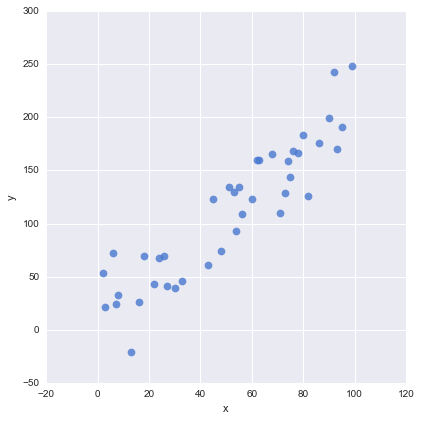

In [4]:
g = sns.lmplot(x='x', y='y', data=df, fit_reg=False 
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

Let's create and fit a frequentist ordinary least squares (OLS) model. Notice how, thanks to Patsy, we can use "R formulas" for symbolic model specification.

We first do model specification as design matrices...

In [5]:
## Model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

... and then fit the OLS model and print results

In [6]:
## fit and print
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     190.5
Date:                Thu, 13 Oct 2016   Prob (F-statistic):           2.20e-16
Time:                        19:56:56   Log-Likelihood:                -187.11
No. Observations:                  40   AIC:                             378.2
Df Residuals:                      38   BIC:                             381.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      9.1123      8.541      1.067      0.2

Notice that the resulting:
* Slope $ x = 1.99 $, with standard deviation $ \sigma_{x} = 0.144 $, is not too far away from the actual value **2.00.** 
* Intercept $ a = 9.11  $, with standard deviation $ \sigma_{a} = 8.54 $ is considerable off from the predicted value versus the actual **5.00.**

Time to create and fit a Bayesian OLS model using PyMC3. We define a model specification and take samples of $\beta$ from the *joint probability distribution* and minimize the log-loss when computed against the *posterior predictive distribution.*

This is what will happen in the next cell to define our model:

* We use a **Generalized Linear Model.** The generalized linear model (GLM) is a flexible generalization of ordinary linear regression that allows for response variables that have error distribution models other than a normal distribution. 


* We optimize to find the **Max A-Posteriori** (MAP) estimate of the joint probability distribution, and thus a good starting point for the sampler.


* We use the **NUTS** (No-U-Turn Sampler) sampler to take **num_samples** samples from the joint probability distribution of $ \beta $ and converge via evaluating and iteratively minimising the loss on the posterior predictive distribution $ \hat{y} $ with respect to the true values $ y $. No-U-Turn Sampler adaptively sets path lengths in the Markov Chain Monte Carlo (MCMC) algorithm

Consider yourself warned: The execution of the next cell **may** take a while. Grab your coffee just in case...

In [7]:
# Set the number of samples. 
num_samples = 3000

# Define model
with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model specification
    ## Use Normal likelihood (uses Cauchy distribution for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    ## This is why we executed from scipy.optimize import fmin_powell
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=True)

    ## Let's go NUTS!. 
    # These are the traces we will need for visualization
    trc_ols = pm.sample(num_samples, start=start_MAP, step=pm.NUTS())

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 3000 of 3000 complete in 4.5 sec

The results of the above are in the form of a *trace* for each $\beta$ parameter, each *num_samples* samples long. We now visualize the trace of the last 1000 samples; we hope those last 1000 samples are already converged. 

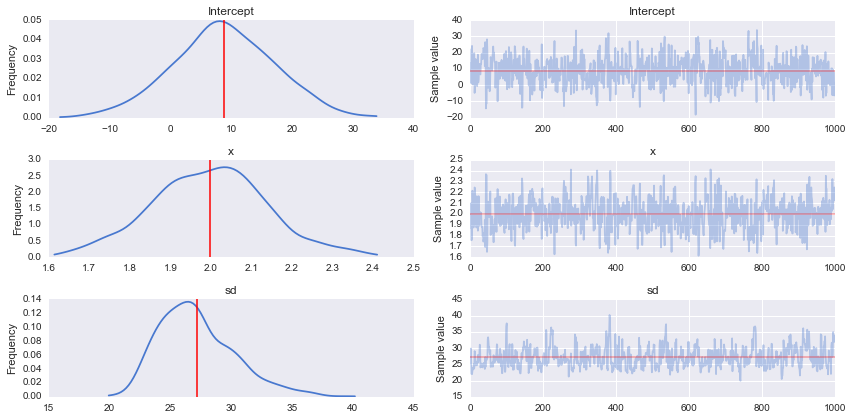

In [8]:
ax = pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),  
    lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()})

* On the left-hand side we show the traces form a *marginal distribution* on each parameter letting us declare distributional statistics directly from the data with no assumptions about their functional form.


* On the right-hand side we show raw trace values that can be used to create 1000 posterior predictions of $ y $ for any $ x $. This takes place **without** any assumptions about the functional form. 

Lets take a look at the parameter values

In [9]:
print(pm.df_summary(trc_ols[-1000:]))  

                mean        sd  mc_error    hpd_2.5   hpd_97.5
Intercept   8.794805  8.331877  0.362215  -7.673787  24.655747
x           1.997008  0.141880  0.006450   1.705196   2.271600
sd         27.183605  3.127393  0.184067  21.914995  33.598006


Here is the summary:

* Intercept:  $ \mu = 8.79 $ , $ \sigma = 8.33 $ 
* Slope ($ x $) $ \mu = 1.99 $ , $ \sigma = 0.14 $
* Gaussian noise: $ \mu = 27.18 $ , $ \sigma = 3.12 $

Notice that the Bayesian OLS has made very similar estimates of the parameter values as the Frequentist OLS. This is good news as both models are quite similar. In addition, we have this time an estimate for the parameter of the noise we introduced in our linear data; relatively close to the actual value of $30.$

In addition:

* **Frequentist approach**. In the Frequentist ordinary least-square model the **confidence intervals (CI) ** are created by fitting a Normal distribution over the point-estimate maximum likelihood estimate values of each parameter.


* **Bayesian approach**. In the Bayesian inferential method, we can simply use the distribution of samples (after convergence) to learn the uncertainty in the parameter values. This is, we have real intervals, **credible regions (CR)** on the estimates of the parameter values.

Let's take a look at model posterior prediction. For this goal we define the following function:

In [10]:
def plot_posterior_credible_regions(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    The name of the functions says it all...
    '''

    ## Traces of interest
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## Recreate likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    # For mean...
    like_mu = np.dot(X,trc_mu.T)
    # For standard deviation...
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Blues')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)


Let's see what the previous function provides...

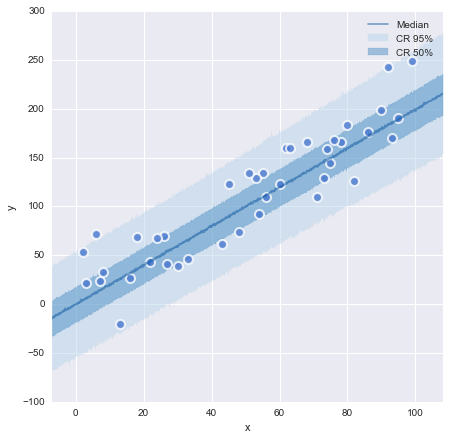

In [11]:
xlims = (df['x'].min() - np.ptp(df['x'])/10  
                 ,df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_credible_regions(mdl_ols, trc_ols, df, xlims)

We have used parameter trace values to generate new predictions $ \hat{y} $ according to the model specification. We have then measured **credible regions** over that distribution and overplotted a line of fit and **credible regions** on the original datapoints. The two credible regions shown are at 50% and 95%. This means that we expect 50% of the datapoints to fall within the 50% CR and likewise for the 95% CR. 